# **프로젝트: 한영 번역기 만들기**
Attention 기법을 추가한 Seq2seq기반 한영번역기를 직접만들어봅시다.
# **Step1. Import necessary libraries**

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# Mecab 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import time
import re
import io
import os
from konlpy.tag import Mecab

# **Step2. Import Data**
데이터는 다음 경로에서 한영 병렬 말뭉치를 다운받습니다 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

먼저 파일을 불러오고 5개의 문장을 출력하는 함수를 정의해주겠습니다.

In [ ]:
path_to_file = "/content/drive/MyDrive/GoingDeeper_Data/GD4/korean-english-park.train/"

def load_file(filename):
    with open(path_to_file + "{}".format(filename), "r") as f:
        raw = f.read().splitlines()
    
    print("Data Size:", len(raw))
    print("Example:")
    for sen in raw[:10]:
        print(">>", sen)

    return raw

load_file()함수를 이용해서 한글 말뭉치와 영어 말뭉치를 불러오겠습니다.

In [ ]:
# 한국어 말뭉치
raw_ko = load_file("korean-english-park.train.ko")

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.


In [ ]:
# 영어 말뭉치
raw_en = load_file("korean-english-park.train.en")

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
>> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
>> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help sta

위 예문에서 한국어와 영어의 3번째 문장을보면 내용이 정확히 일치하지가 않는다. 
- " 그러나 이것은 또한 책상도 필요로 하지 않는다."
- "  Like all optical mice, But it also doesn't need a desk. "

이는 영어 말뭉치에서 이전문장의 내용 끝의 일부가 그 다음 문장으로 넘어와버려서 생긴 문제이다. 이러한 문장이 어느정도 있는지는 모르겠지만, 해당 문제는 결과에 막대한 영향은 아니겠지만 노이즈로 작용할 수 있다.
# **Step3. Preprocessing Data**
## 중복치 제거

In [ ]:
raw = zip(raw_ko, raw_en)
set_raw = set(raw)
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)
print('중복제거된후 Data길이:', len(set_raw))

중복제거된후 Data길이: 78968


## 전처리 함수 작성

In [ ]:
def preprocessing(sentence, eng=False):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 구두점과 단어분리
    sentence = re.sub(r'[" "]+', " ", sentence)  
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence) # 특수문자 제거
    sentence = sentence.strip()
    
    if eng:
        sentence = '<start> ' + sentence + ' <end>'

    return sentence

## 전처리된 한국어와 영어 말뭉치 만들기

In [ ]:
preprocessed_kor = []
preprocessed_eng = []

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
    preprocessed_kor.append(preprocessing(kor))
    preprocessed_eng.append(preprocessing(eng, eng=True))

print("Korea:", preprocessed_kor[0])
print("english:", preprocessed_eng[0])

Korea: 메르켈 총리는 독일은 유대인 학살을 부끄럽게 여긴다 며 생존자들에게 고개 숙여 경의를 표하고 그들을 존경한다 고 말했다 .
english: <start> i bow my head before the survivors and i bow my head before you in tribute to the fact that you were able to survive . <end>


## 길이가 긴 문장 제거
: 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. 문장의길이가 120이하인 데이터를 선별해봅시다.

(array([  18.,  107.,  156.,  168.,  345.,  310.,  666.,  580.,  948.,
         738., 1263.,  954., 1648., 1084., 1749., 1260., 1771., 1174.,
        1495.,  929., 1262.,  815., 1098.,  709., 1020.,  647.,  961.,
         687., 1066.,  754., 1113.,  788., 1201.,  793., 1216.,  853.,
        1434.,  853., 1365., 1330.]),
 array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. ]),
 <a list of 40 Patch objects>)

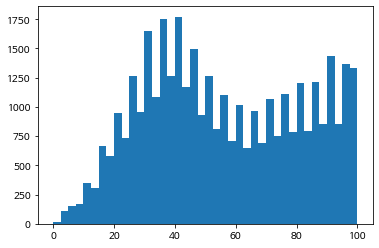

In [ ]:
kor_corpus = []
eng_corpus = []

for kor, eng in zip(preprocessed_kor, preprocessed_eng):
    if len(kor) <= 100 and len(eng) <= 100:
        kor_corpus.append(kor)
        eng_corpus.append(eng)

# 전체데이터 문장길이 분포 확인
total_data = kor_corpus + eng_corpus
len_list = [len(sentence) for sentence in total_data]
plt.hist(len_list, bins=40)

In [ ]:
len(eng_corpus)

18664

## 토큰화

In [ ]:
# 토큰화함수 정의
max_len = 100

def tokenize(corpus, kor=False, eng=False):
    if kor:
        mecab = Mecab()
        morph = [(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
        tokenizer.fit_on_texts(morph)
        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)
       
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
        tokenizer.fit_on_texts(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, tokenizer

In [ ]:
# 토큰화함수 적용
enc_tensor, enc_tokenizer = tokenize(kor_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(eng_corpus, eng=True)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 21789
English Vocab Size: 17796


In [ ]:
enc_tensor[0]

array([2714, 1591,  178,  170,    3, 1055,  435,    4,  238,    8,   81,
       1592,   59,   42,    2,   12,   55,    2,    1,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
dec_tensor[0]

array([   1,  411,  300, 2319, 1851,   10,  256,   12,   13,   14,    7,
       2320,   24, 1150,   39,    4, 2139,    3,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

# **Step4. Model Design**
이제부터 아래 그림처럼 각각 1개의 GRU를 갖는 인코더-디코더구조를 설계할 것입니다.
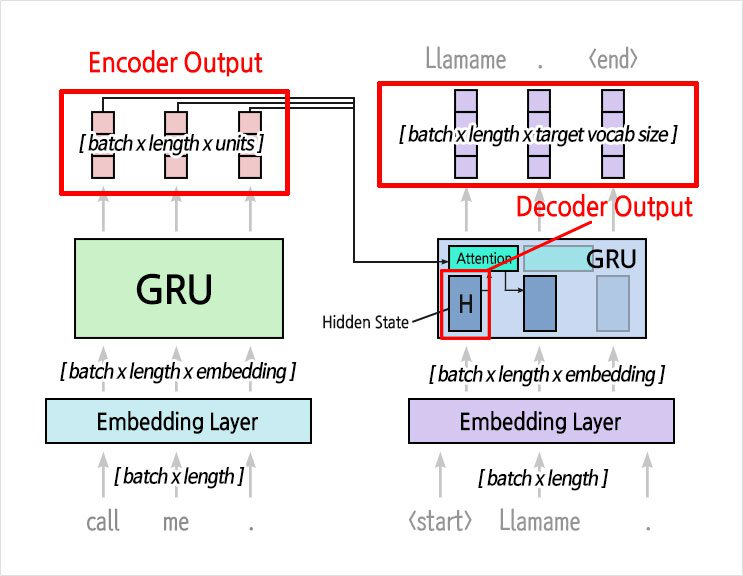

## BahdanauAttention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 가중치 차원설정 : hiddenstate를 몇차원으로 출력할것인지
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc) # [W x h]
        h_dec = tf.expand_dims(h_dec, 1) # 해당벡터의 1번자리의 차원을 늘려줌
        h_dec = self.w_dec(h_dec) # [W x h]

        score = self.w_com(tf.nn.tanh(h_dec + h_enc)) # alignment score 계산 

        attn = tf.nn.softmax(score, axis=1) # 확률분포 계산

        context_vec = attn * h_enc # 가중치가 부여된 맥락벡터계산
        context_vec = tf.reduce_sum(context_vec, axis=1) # 각 맥락벡터를 다 더해줌

        return context_vec, attn

## Encoder
: 인코더는 모든 시각의 Hidden State를 출력합니다.

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

## Decoder
: 디코더는 **인코더의 출력**과 디코더의 **이전시각의 Hidden state**로 어텐션을 취하여 현재시각의 Hidden state를 만들어냅니다. 그리고 현재시각의 단어로 예측된 것을 실제 정답과 대조해 loss를 구합니다.

여기서 초기의 Hidden state는 일반적으로 인코더의 마지막시각의 Hidden state를 이용합니다.

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec) # 맥락벡터 출력
        out = self.embedding(x) # 임베딩벡터 출력
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1) # 맥락벡터와 임베딩벡터를 concat시킴
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

# **Step5. Optimizer & Loss Design**
인코더-디코더 구조의 경우 입출력이 단순하지 않아 학습과정을 직접 정의해줘야 합니다. 첫 순서는 Optimizer와 Loss입니다.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # from_logits : 소프트맥스를 거쳐서들어올지말지 결정

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # equal() : real값중에 0과 같은지아닌지를 True/False로 나타내줌, logical_not() : T/F값들을 반대로 변환
    loss = loss_object(real, pred) # get loss
    mask = tf.cast(mask, dtype=loss.dtype) # change the type of mask element 
    loss *= mask # multiply loss and mask
    
    return tf.reduce_mean(loss) # reduce_mean() : 두번째 인자를 적지 않은 경우, loss배열 전체 원소의 합을 원소 개수로 나누어 평균을 계산합니다. 

여기서 fit()함수를 사용할 수 없는 이유는 바로 Loss함수 때문입니다. 앞서 말한것처럼 인코더-디코더 구조는 학습과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하죠.
- SparseCategoricalCrossentropy() : 모델이 출력한 확률분포와 정수인덱스 답안을 비교해 cross entropy값을 구해줍니다
- Mask : 마스크는 정답지에서 패딩토큰을 찾아내어 그부분에 대한 Loss는 구하지 않도록 하는 역할을 해주빈다

# **Step6. Train_step Design**
train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 

In [ ]:
# 해당 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다.
# 첫번째 에포크가 다른 에포크보다 약간의 시간이 더걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문입니다
@tf.function

def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        # 인코더에 소스문장을 전달해 컨텍스트 벡터인 enc_out을 생성
        enc_out = encoder(src)

        # 디코더의 초기 hidden state는 인코더의 마지막state로 정의
        h_dec = enc_out[:, -1]

        # 디코더에 입력으로 전달할 <start>토큰 문장 생성
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            # start문장과 enc_out과 hidden state를 기반으로 다음단어를 예측(pred)
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            # 예측된단어(pred)와 정답(tgt[:, t])간의 Loss구해서 더해줌
            loss += loss_function(tgt[:, t], pred)

            # 정답 단어를 다음 입력으로 사용
            dec_src = tf.expand_dims(tgt[:, t], 1)
    
    batch_loss = (loss / int(tgt.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

# **Step7. Start Train**
다음 순서는 본격적으로 훈련을 시작하는 부분입니다

In [ ]:
EPOCHS = 30
BATCH_SIZE = 64
units = 128
embedding_dim = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

for epoch in range(EPOCHS):
    total_loss = 0

    # 각 배치의 시작 인덱스를 idx_list배열에 저장합니다
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    
    # 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 합니다
    random.shuffle(idx_list)
    t = tqdm(idx_list) # tqdm

    # 각 미니배치를 train_step()함수에서 학습합니다
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        total_loss += batch_loss
        t.set_description_str('Epoch %2d' % (epoch + 1)) # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch 30: 100%|██████████| 292/292 [01:00<00:00,  4.84it/s, Loss 0.4122]


# **Step8. Evaluate Model**
훈련이 완료된 모델을 평가해보고, Attention Map을 시각화해봅시다

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    sentence = preprocessing(sentence) # 전처리 함수 적용
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()]) # 문장을 정수시퀀스로변환
    inputs = pad_sequences(inputs,
                           maxlen=enc_tensor.shape[-1],
                           padding='post') # 패딩
    result = ''

    enc_out = encoder(inputs) # 인코더의 출력(hidden state) 저장
    dec_hidden = enc_out[:, -1] # 인코더 출력의 마지막시각의 hidden state만 저장
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0) # numpy=array([[1]]), shape=(1, 1)

    for t in range(dec_tensor.shape[-1]):
        # 예측단어, 다음시각의 hidden state, 가중치 저장
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, )) # 한줄로 형태변환
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마는 대통령이다 .
Predicted translation: and a lot of the world <end> 


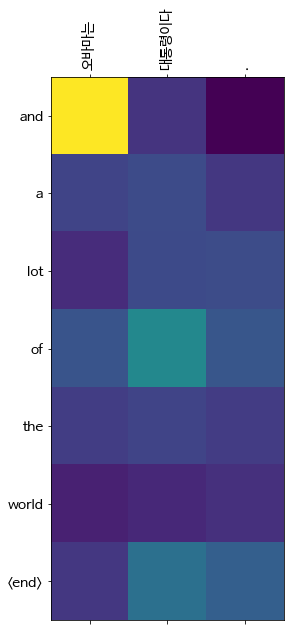

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: 1 . s a lot of the world <end> 


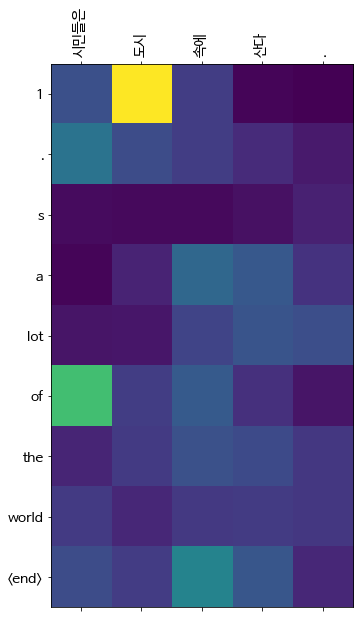

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: we will be a lot of people . <end> 


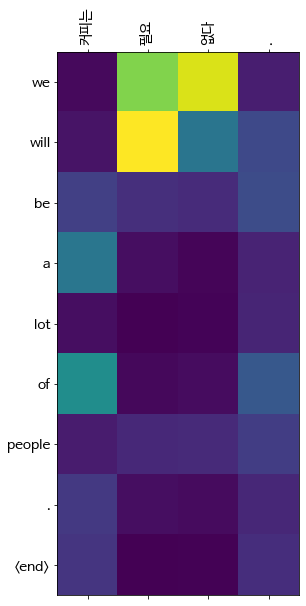

In [ ]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: two weeks . <end> 


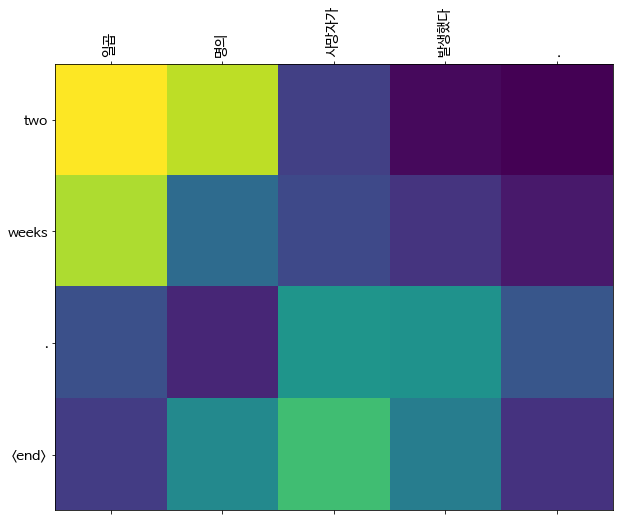

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고
- 맷플롯맆은 한글폰트가 지원이 안된다. 따라서 따로 한글폰트를 설치해줘야한다. 하지만 이과정때문에 시간 소요가 많이됐었다. 한글폰트를 사용하려면 먼저 폰트를 설치시켜준다음에 런타임을 다시시작해줘야한다. 하지만 초반에 이과정을 진행하지않고 맨마지막에 Attention Map을 시각화할때 한글폰트가 필요하다는것을 깨달았다. 하지만 런타임을 다시시작해줘야됐고, 학습시간이 매우오래걸리는 것이었기때문에 매우 오래걸렸다...
- 위에서도 언급했듯이, 데이터가 별로 좋지않았다. 초반에 데이터를 불러오고 몇개 뽑아보니까 제대로 번역이 되어있지않았다. 때문에 성능에도 많은 영향을 미친것같다.
- 인코더디코더 구조는 여러번 본적있지만, 볼때마다 이해가 어려운것같다. 개념상 이해는 할 수 있지만, 이걸 코드로 구현해서 이해하기엔 아직 실력이 부족한것 같다.
- 딱히 기대는하지 않았지만, 역시나 제대로된 변역은 되지않았다..